In [1]:
import matplotlib.pyplot as plt
import sys
import pickle
import numpy as np

sys.path.append('../code')
import tessDiffImage
import tessCentroids
from tess_stars2px import tess_stars2px_function_entry
import tessprfmodel as tprf

In [2]:
def quick_flux_centroid(arr, extent, constrain=True):
    xpix = np.linspace(extent[0], extent[1]-1, arr.shape[1])
    ypix = np.linspace(extent[2], extent[3]-1, arr.shape[0])
    X, Y = np.meshgrid(xpix, ypix)
    normArr = arr.copy() - np.median(arr.ravel())
    sum_f = np.sum(normArr.ravel())
    sum_x = np.sum((X*normArr).ravel())
    sum_y = np.sum((Y*normArr).ravel())
    
    xc = sum_x/sum_f
    yc = sum_y/sum_f
    
    if constrain:
        # if the centroid is outside the extent then return the center of the image
        if (xc < extent[0]) | (xc > extent[1]):
            xc = np.mean(extent[0:2])

        if (yc < extent[2]) | (yc > extent[3]):
            yc = np.mean(extent[2:])

    return [xc, yc]


We use the same exmaple as the notebook example_diffimages.  First we make and display the difference image, exactly like in that notebook.  See example_diffimages for details of what's happening.

In [3]:
star = {}
star['id'] = 25375553
star['raDegrees'] = 328.76768
star['decDegrees'] = -22.61258

planet0 = {}
planet0['TOI'] = 143.01
planet0['period'] = 2.31097
planet0['epoch'] = 1325.58249
planet0['durationHours'] = 3.129

In [4]:
from tess_stars2px import tess_stars2px_function_entry

outID, outEclipLong, outEclipLat, outSec, outCam, outCcd,\
    outColPix, outRowPix, scinfo = tess_stars2px_function_entry(star['id'], star['raDegrees'], star['decDegrees'])

print(outSec, outCam, outCcd)

[ 1 28 68] [1 1 1] [3 3 3]


We will get make difference images for all possible sectors, and need to record the ccd.  

In [5]:
star['sector'] = None
star['cam'] = None
star['ccd'] = None
star['planetData'] = [planet0]
# If you have quality flags for each cadence in the sector in a file, name the file here; otherwise None
star['qualityFiles'] = None
# If you have quality flags for each cadence in the sector in an array, put the array here; otherwise None
star['qualityFlags'] = None

tdi = tessDiffImage.tessDiffImage(star, spiceFileLocation = "..", qlpFlagsLocation = "../../QLP_qflags/")

tdi.make_ffi_difference_image(thisPlanet=0)

For various reasons not all sectors will get difference images, so see what sectors actually have difference images.

In [6]:
tdi.sectorList

[1, 28]

In [7]:
sectorIndex = 1 # make sure outSec[sectorIndex] is in tdi.sectorList
if outSec[sectorIndex] not in tdi.sectorList:
    raise ValueError(str(sectorIndex) + " is not a valid sector index.")

fname = 'tic25375553/imageData_TOI_143.01_sector' + str(outSec[sectorIndex]) + '.pickle'
with open(fname, 'rb') as f:
    imageData = pickle.load(f)

Text(0.5, 1.0, 'Direct Image (Close-up)')

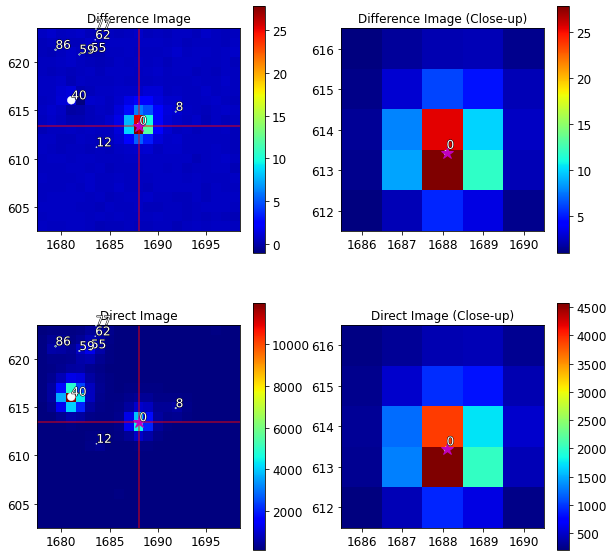

In [8]:
diffImageData = imageData[0]
catalogData = imageData[1]

fig, ax = plt.subplots(2,2,figsize=(10,10))
tdi.draw_pix_catalog(diffImageData['diffImage'], catalogData, catalogData["extent"], ax=ax[0,0], fs=14, ss=60, filterStars=True, dMagThreshold=4, annotate=True)
tdi.draw_pix_catalog(diffImageData['diffImage'], catalogData, catalogData["extentClose"], ax=ax[0,1], fs=14, ss=60, filterStars=True, dMagThreshold=4, annotate=True, close=True)
tdi.draw_pix_catalog(diffImageData['meanOutTransit'], catalogData, catalogData["extent"], ax=ax[1,0], fs=14, ss=60, filterStars=True, dMagThreshold=4, annotate=True)
tdi.draw_pix_catalog(diffImageData['meanOutTransit'], catalogData, catalogData["extentClose"], ax=ax[1,1], fs=14, ss=60, filterStars=True, dMagThreshold=4, annotate=True, close=True)
ax[0,0].set_title('Difference Image')
ax[0,1].set_title('Difference Image (Close-up)')
ax[1,0].set_title('Direct Image')
ax[1,1].set_title('Direct Image (Close-up)')

Now we perform a centroid analysis to find the position of the star that is making the difference image.  We use the principle that, if all the change in the pixel flux is due to changes in one star such as a transit, then the difference image contain that star's image.  The star's image is determined by the TESS Pixel Response Function (PRF).

We will use PRF centroiding, which finds the position of the TESS PRF that results in pixels that are the best match for the difference image. That pixel position should correspond to the position of the star causing the change.

We perform PRF centroiding using a nonliner minimization of the sum of the squares of the difference between a synthetic image created using the PRF and the observed difference image.  Our synthetic image is 
$$ I = a*PRF(x,y) + o. $$  We find the set $(x, y, a, o)$ so that the image $I$ best matches the difference image in a least squares sense.

To seed the minimzation, we compute a flux-weighted centroid.  We do not expect this centroid to be very accurate because of residual pixel values in the difference image.

We do our centroiding in a 7x7 closeup of the diference imaging, rather than the default 5x5 closeup.  This helps us get a good seed position from the flux-weighted centroid.  So first we extract the central 7x7 pixels, and define the appropriate extent.

Create the TESS PRF object.

In [9]:
prf = tprf.SimpleTessPRF(shape=diffImageData["diffImage"].shape,
                                    sector = outSec[sectorIndex],
                                    camera = outCam[sectorIndex],
                                    ccd = outCcd[sectorIndex],
                                    column=catalogData["extent"][0],
                                    row=catalogData["extent"][2],
#                                     prfFileLocation = "../../tessPrfFiles/"
                        )

Compute the centroid

In [10]:
fitVector, prfFitQuality, fluxCentroid, closeDiffImage, closeExtent = tessCentroids.tess_PRF_centroid(prf, 
                                                           catalogData["extent"], 
                                                           diffImageData["diffImage"], 
                                                           catalogData)

In [11]:
print("PRF fit quality = " + str(prfFitQuality))

PRF fit quality = 0.9951279775145075


Show the flux-weighted and PRF-fit centroids on the difference image, along with the position of the target star (the first star in the catalog data).

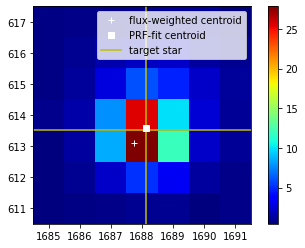

In [12]:
plt.imshow(closeDiffImage, cmap='jet', origin='lower', extent=closeExtent)
plt.plot(fluxCentroid[0], fluxCentroid[1], 'w+', label = "flux-weighted centroid", zorder=200)
plt.plot(fitVector[0], fitVector[1], 'ws', label = "PRF-fit centroid", zorder=200)
plt.axvline(catalogData["ticColPix"][0], c='y', label = "target star")
plt.axhline(catalogData["ticRowPix"][0], c='y')
plt.colorbar()
plt.legend()


Make a full-size synthetic difference image to compare with the original difference image.

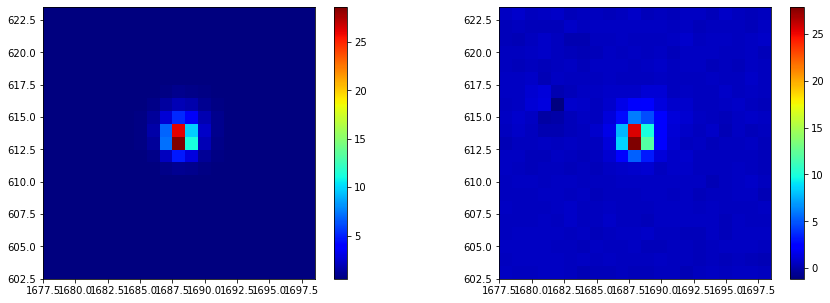

In [13]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.imshow(tessCentroids.render_prf(prf, fitVector, catalogData), 
           cmap='jet', origin='lower', extent=catalogData["extent"])
plt.colorbar()
plt.subplot(1, 2, 2)

plt.imshow(diffImageData["diffImage"], 
           cmap='jet', origin='lower', extent=catalogData["extent"])
plt.colorbar();


Assess the quality of the difference image by computing the correlation between the synthetic image and the difference image.  A perfect match would have correlation = 1.